In [22]:
import networkx as nx
from gurobipy import *
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import random
import warnings
warnings.filterwarnings('ignore')
# import import_ipynb #to import other ipynb files
# Our files
import pricing
import opt


In [23]:
def get_extreme_points(coordinates):
    df2=coordinates.sort_values(by='x')
    df3=df2.sort_values(by='y')
    t = np.round(list(df3.iloc[0])[0],0)
    df2=coordinates.sort_values(by='x',ascending=False)
    df3=df2.sort_values(by='y',ascending=False)
    s = np.round(list(df3.iloc[0])[0],0)
    return s, t

In [24]:
def myplot(G, pos, color, NodeSize, LineWidth):
    plt.rcParams['figure.figsize'] = [8, 10]
    nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(data=False),node_size=NodeSize,node_color=color)
    nx.draw_networkx_edges(G,pos,edgelist=G.edges(data=False),width=LineWidth,arrows=False)
    # nx.draw_networkx_labels(G,pos,labels=label_list)
    plt.show()

In [25]:
# place_name = 'Champaign, IL, USA'
# place_name = 'Chicago, IL, USA'
place_name = 'IL, USA'
G = nx.Graph(ox.graph_from_place(place_name, custom_filter='["highway"~"primary|secondary"]'))

In [26]:
# pos=nx.spring_layout(G)
pos={}  # For map like graphs
coordinates = pd.DataFrame(columns=['ID','x','y'])
for u, data in G.nodes(data=True):
    pos[u]=(data['x'],data['y'])
    coordinates.loc[len(coordinates.index)]=[int(u),data['x'],data['y']]

In [27]:
gas_stations=[]
color=[]; NodeSize = []
label_list={}
s, t = get_extreme_points(coordinates)
print(s,t)
for i in G.nodes():
    if i == s:
        color.extend(['k'])
        NodeSize.extend([20])
    elif i == t:
        color.extend(['k'])
        NodeSize.extend([20])
    else:
        if np.random.rand() < 0.10:
            gas_stations.append(i)
            label_list[i]=str(i)
            color.extend(['r'])
            NodeSize.extend([10])
        else:
            color.extend(['b'])
            label_list[i]=''
            NodeSize.extend([1])
print('#stations:',len(gas_stations),'\n#nodes:' ,G.number_of_nodes())

235037228.0 5735310533.0
#stations: 1469 
#nodes: 15048


In [28]:
dfgs=pd.DataFrame(columns=['ID','X','Y'])
for i in gas_stations:
    dfgs.loc[len(dfgs.index)]=[i,G.nodes[i]['x'],G.nodes[i]['y']]
dfgs.sort_values(by='Y',inplace=True,ascending=True)
# dfgs.head()

22153


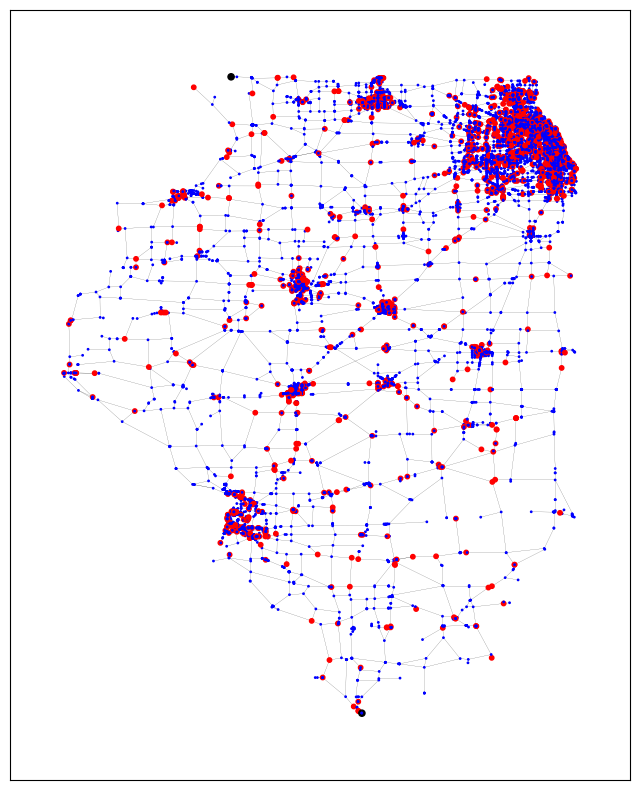

In [29]:
LineWidth={}
itercount=0
print(G.number_of_edges())
edgelist=copy.deepcopy(G.edges())
for u,v in edgelist:
    itercount +=1
    if u==v:
        G.remove_edge(u,v)
        continue
    # LineWidth.extend([0.5])
    if (u,v) in LineWidth.keys():
        G.remove_edge(u,v)
        continue
    LineWidth[(u,v)]=0.1
O_lineWidth=copy.deepcopy(LineWidth)
plist = list(LineWidth.values())
myplot(G,pos,color, NodeSize, plist)

In [30]:
def get_averages(G):
    density=[]
    for i in random.sample(G.nodes(),500):
        d, X0 = pricing.get_price(G.nodes[i]['y'], G.nodes[i]['x'])
        density.append(d)
    return density

In [31]:
from itertools import islice
def k_shortest_paths(G, source, target, k, weight='length'):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )

def Kedge_dis_shortest_paths(G, source, target, k, weight='length'):
    paths=[]
    H_=nx.DiGraph(G)
    for j in range(k):
        try:
            path = nx.shortest_path(H_,source,target,weight=weight)
        except nx.NetworkXNoPath:
            return paths
        for i in range(1+10,len(path)-10):
            H_.remove_edge(path[i-1],path[i])
        paths.append(path)
    return paths

In [32]:
paths = Kedge_dis_shortest_paths(G, s, t, 5)

In [33]:
# for path in paths:
#     for i in range(1,len(path)):
#         LineWidth[(path[i-1],path[i])]=1
#     plist = list(LineWidth.values())
#     myplot(G,pos,color, NodeSize, plist)
#     # print(path)
#     LineWidth=copy.deepcopy(O_lineWidth)

In [67]:
def path_as_edgelist(path_):
    edgelist=[]
    for i in range(1,len(path_)):
        edgelist.append((path_[i-1],path_[i]))
    return edgelist

In [35]:
def clean_graph(G_):
    edges_={}
    edgelist_=copy.deepcopy(G.edges())
    for u,v in edgelist_:
        if u==v:
            G_.remove_edge(u,v)
            continue
        if (u,v) in edges_.keys():
            G_.remove_edge(u,v)
        continue
    edges_[(u,v)]=1

In [36]:
def enrich_graph(G, path):
    H1=nx.DiGraph(G)
    print(G.number_of_nodes(),G.number_of_edges())
    for i in range(len(path)):
        lat=G.nodes[path[i]]['y']
        lang=G.nodes[path[i]]['x']
        try:
            X_=nx.DiGraph(ox.graph_from_point((lat,lang),500,dist_type="network",network_type="drive"))
        except nx.NetworkXPointlessConcept:
            continue
        except ValueError:
            continue
        A=nx.compose(A,X_)
        print(A.number_of_nodes(),A.number_of_edges())
    clean_graph(A)
    H1=nx.compose(H1,A)
    print(H1.number_of_nodes(),H1.number_of_edges())
    for u in H1.nodes():
        pos[u]=(H1.nodes[u]['x'],H1.nodes[u]['y'])
    return H1

In [37]:
def quick_filter(G,ID,dfgs,cutoff=10000):
    stations=[]
    clat=G.nodes[ID]['y']; clang=G.nodes[ID]['x']

    #get all limits
    # Latitude: 1 deg = 110.574 km. Longitude: 1 deg = 111.320*cos(latitude) km
    ulimit=clat+cutoff/(2000*110.574)
    dlimit=clat-cutoff/(2000*110.574)
    rlimit=clang+cutoff/(2000*111.320*abs(np.cos(clat)))
    llimit=clang-cutoff/(2000*111.320*abs(np.cos(clat)))

    for i in range(len(dfgs.index)):
        if dlimit < dfgs.iloc[i]['Y'] < ulimit:
            if llimit < dfgs.iloc[i]['X'] < rlimit:
                stations.append(dfgs.iloc[i]['ID'])
    if len(stations) > 20:
        return quick_filter(G,ID,dfgs,cutoff/2)
    else:
        return stations

In [38]:
def nearest_station(G,ID,gas_stations,cutoff=10000):
    #Filter on gas stations based on bbox
    stations=quick_filter(G,ID,dfgs,cutoff)
    # print('filtered stations', stations)
    min_distance=cutoff; minID=None
    for i in stations:
        try:
            dist=nx.shortest_path_length(G,ID,i,weight='length')
        except nx.NetworkXNoPath:
            continue
        if dist<min_distance:
            min_distance=dist; minID=i
    return minID, min_distance

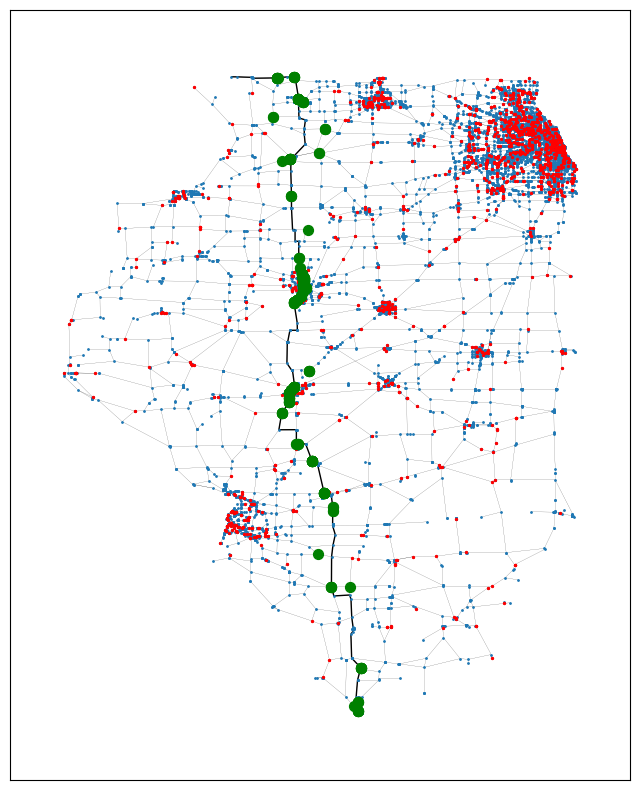

1 235051867
2 235012812
3 235065192
4 3387187933
5 234975834
6 235122108
7 252706670
8 252706210
9 237191996
10 237205216
11 237200860
12 2355927397
13 237175591
14 2355927399
15 1419734826
16 237179625
17 237197770
18 7092028330
19 1745339691
20 1745339666
21 7092028346
22 237197758
23 237197754
24 237197181
25 237202122
26 237193096
27 237199813
28 10105395642
29 237177449
30 236794773
31 3699230077
32 236794843
33 236790740
34 236788264
35 236788257
36 236782624
37 236776066
38 236776063
39 237378032
40 237381201
41 3261589645
42 3261589643
43 237389815
44 658944357
45 658944356
46 237403025
47 9992319425
48 237398563
49 237390253
50 233907898
51 233947921
52 233907869
53 233947775
54 233947770
55 233886802
56 233915599
57 233947434
58 233915552
59 237158590
60 237157661
61 237151926
62 236499605
63 236503447
64 273627498
65 236784463
66 273627277
67 2751230182
68 236784399
69 236794840
70 236794823
71 1935521444
72 1935521288
73 1386945777
74 2031120333
75 2031120321
76 2031120317


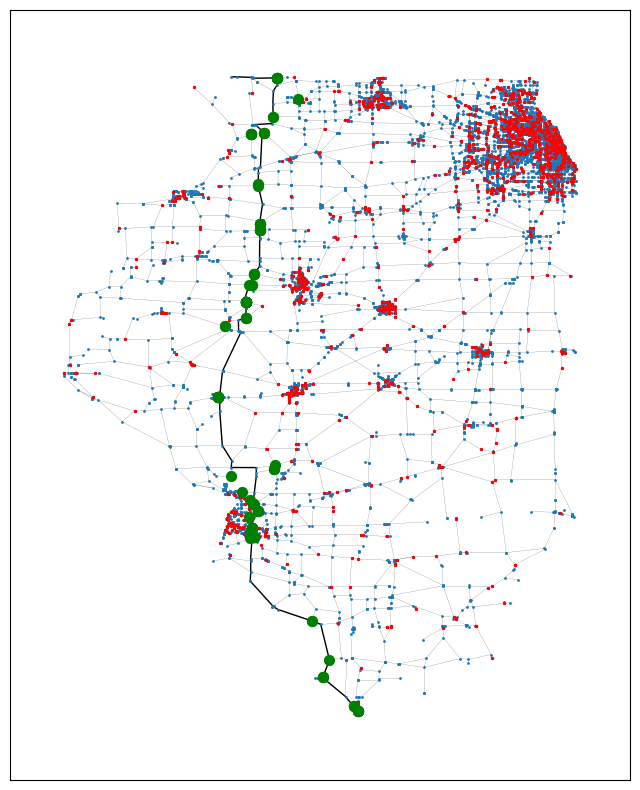

1 235051867
2 235012812
3 235065192
4 3387187933
5 234975834
6 235122108
7 252706670
8 237192605
9 237194641
10 237185758
11 233994503
12 233998200
13 3162914287
14 3162914283
15 3162914258
16 3162914154
17 3162914131
18 234001719
19 233994068
20 233993095
21 237375130
22 237401181
23 237381920
24 234841972
25 234841888
26 234832018
27 234828451
28 234815673
29 6125834900
30 959469896
31 234814381
32 959469909
33 234841633
34 237151940
35 237151998
36 236786011
37 236807385
38 236807398
39 236822885
40 235190305
41 235165335
42 234469044
43 234469029
44 234490248
45 234455303
46 234567912
47 234469394
48 234469399
49 234597449
50 234597417
51 234454543
52 234454547
53 234477667
54 234455809
55 234477656
56 234477420
57 234467808
58 234444563
59 234477061
60 234476894
61 234466466
62 234466311
63 234476448
64 236537801
65 236562276
66 234075761
67 234035218
68 234054468
69 234035211
70 234075755
71 236723507
72 3590364818
73 236748449
74 236748202
75 2104404396
76 2104404458
77 21044044

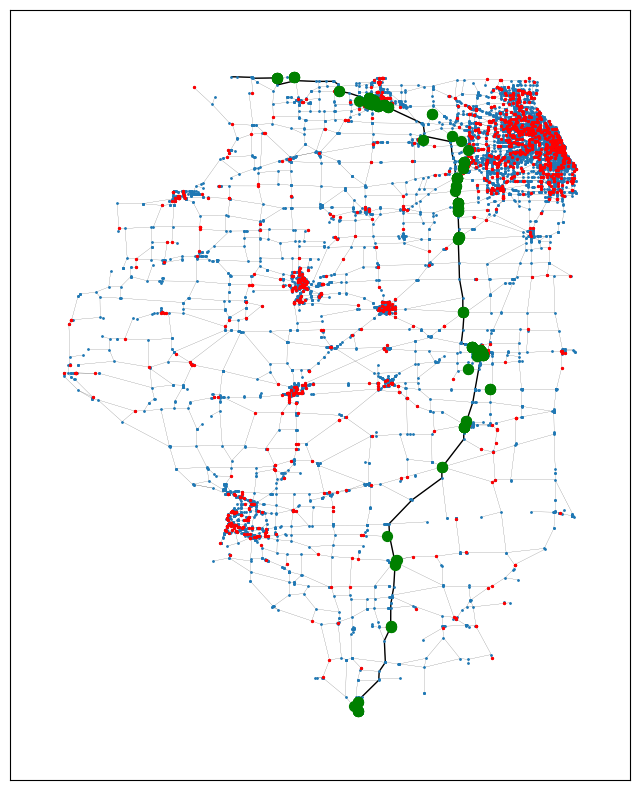

1 235051867
2 235012812
3 235065192
4 3387187933
5 234975834
6 235122108
7 252706670
8 237192605
9 2355927400
10 237175591
11 2355927374
12 237194369
13 237203037
14 237188397
15 237602515
16 237526957
17 237538598
18 237568149
19 7162480889
20 237582251
21 7162480894
22 237581239
23 7561358353
24 237581406
25 7152716667
26 237581436
27 7152716674
28 7157664107
29 7146285264
30 846225426
31 7146285252
32 7576726034
33 237570978
34 7576726040
35 237570930
36 237570917
37 7683904537
38 237570899
39 7696361705
40 7696361730
41 2914563041
42 846145485
43 237556353
44 237587083
45 237540100
46 839461786
47 237569543
48 237525905
49 237537874
50 839753428
51 839753653
52 839753714
53 237562382
54 237562429
55 2395533391
56 2395533413
57 2395533400
58 2395533396
59 5788708498
60 6006703231
61 6006703260
62 6006703261
63 6006703242
64 6006703255
65 237577601
66 237608592
67 6006911459
68 6006911460
69 6006911461
70 6006911462
71 6006911465
72 237604734
73 237599443
74 846244015
75 1350719547
7

Exception ignored in: <function SearchEngine.__del__ at 0x17221cf70>
Traceback (most recent call last):
  File "/Users/samiran/opt/anaconda3/envs/IE532/lib/python3.10/site-packages/uszipcode/search.py", line 196, in __del__
    self.close()
  File "/Users/samiran/opt/anaconda3/envs/IE532/lib/python3.10/site-packages/uszipcode/search.py", line 202, in close
    self.ses.close()
  File "/Users/samiran/opt/anaconda3/envs/IE532/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 1811, in close
    self._close_impl(invalidate=False)
  File "/Users/samiran/opt/anaconda3/envs/IE532/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 1853, in _close_impl
    transaction.close(invalidate)
  File "/Users/samiran/opt/anaconda3/envs/IE532/lib/python3.10/site-packages/sqlalchemy/orm/session.py", line 923, in close
    transaction.close()
  File "/Users/samiran/opt/anaconda3/envs/IE532/lib/python3.10/site-packages/sqlalchemy/engine/base.py", line 2416, in close
    self._do_close

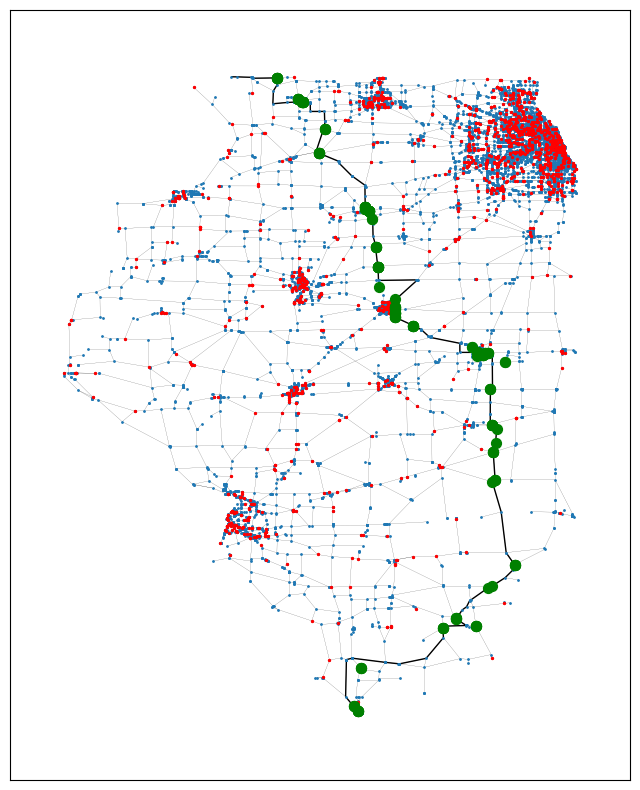

1 235051867
2 235012812
3 235065192
4 3387187933
5 234975834
6 235122108
7 252706670
8 237192605
9 237194641
10 237185758
11 237199343
12 8370752551
13 237186360
14 5237458204
15 237197181
16 1745251363
17 237198740
18 10105392213
19 10105395617
20 237198720
21 1745768005
22 237192053
23 603052624
24 603052741
25 237211469
26 237214650
27 237213729
28 236791365
29 3699261082
30 236774863
31 236778443
32 235344210
33 235339920
34 235342628
35 9851524378
36 9851524372
37 235352215
38 3248707674
39 3248707673
40 235342911
41 9548397063
42 9548397067
43 235243609
44 235257832
45 235252636
46 235282580
47 2356774061
48 2356773989
49 2356773985
50 2356773992
51 2356774122
52 2356774131
53 2356774076
54 8402890889
55 8402890882
56 235298654
57 1820443250
58 235293513
59 1820443323
60 977895094
61 977895088
62 235293490
63 977895077
64 977895075
65 235287761
66 235260404
67 235252892
68 235263180
69 236501353
70 236503430
71 2435767786
72 528518841
73 2435767639
74 1822501257
75 1822501180
76 

In [51]:
mincost=5000; minqty=[]; mpath=[]; mpath1=[]; mneardict={}; lmpath=0; lmpath1=0; lmqty=0
for path in paths:
    # path=path[:30]
    # H1=enrich_graph(G)        #too slow
    nearest={}
    H1=nx.Graph(G)
    nx.draw_networkx_nodes(H1,pos,nodelist=H1.nodes(data=False),node_size=1)
    nx.draw_networkx_edges(H1,pos,edgelist=H1.edges(data=False),width=0.1,arrows=False)
    nx.draw_networkx_nodes(H1,pos,nodelist=gas_stations,node_color='r',node_size=2)
    nx.draw_networkx_edges(H1,pos,edgelist=path_as_edgelist(path),width=1,arrows=False)
    stations_of_interest=[]
    for i in range(1, len(path)-1):    #need not fill up at the destination and source
        nearest[path[i]]={}
        nearest[path[i]]['ID'], nearest[path[i]]['Distance']=nearest_station(H1,path[i],gas_stations,20000)
        nearest[path[i]]['Distance']=nearest[path[i]]['Distance']*0.621371/1000
        if nearest[path[i]]['ID'] is not None:
            stations_of_interest.append(nearest[path[i]]['ID'])
            nearest[path[i]]['Price']=pricing.get_price(H1.nodes[nearest[path[i]]['ID']]['y'], H1.nodes[nearest[path[i]]['ID']]['x'])
        else:
            del nearest[path[i]]
    nx.draw_networkx_nodes(H1,pos,nodelist=stations_of_interest,node_color='g',node_size=50)
    plt.show()

    # Finding mile distances and consolidating the path
    path1=[path[0]]
    mile=[] #Distance for mile[i] is distance betweeen path[i] and path[i+1]
    temp_mile=0
    for i in range(1, len(path)):
        print(i,path[i])
        if path[i] in nearest.keys():
            path1.append(path[i])
            mile.append(temp_mile+H1.edges[(path[i-1],path[i])]['length']*0.621371/1000)
            temp_mile=0
        else:
            temp_mile += G.edges[(path[i-1],path[i])]['length']*0.621371/1000
    path1.append(path[len(path)-1])
    mile.append(temp_mile)
    cost, quantities = opt.refuel_opt(nearest, mile, path1)
    if cost<mincost:
        mincost=cost; minqty=quantities.copy();
        mpath1=path1.copy(); mpath=path.copy(); mneardict=nearest.copy();
print(mincost)

In [52]:
print(mincost)
fill_stations=[]; fill_qty=[]
for i in range(len(minqty)):
    qty = minqty[i]
    if qty >0:
        fill_qty.append(qty)
        fill_stations.append(mneardict[mpath1[i]]['ID'])

33.304


In [63]:
print(len(mpath))

287


In [66]:
for i in range(1,len(mpath)):
    print(mpath[i])

235051867
235012812
235065192
3387187933
234975834
235122108
252706670
252706210
237191996
237205216
237200860
2355927397
237175591
2355927399
1419734826
237179625
237197770
7092028330
1745339691
1745339666
7092028346
237197758
237197754
237197181
237202122
237193096
237199813
10105395642
237177449
236794773
3699230077
236794843
236790740
236788264
236788257
236782624
236776066
236776063
237378032
237381201
3261589645
3261589643
237389815
658944357
658944356
237403025
9992319425
237398563
237390253
233907898
233947921
233907869
233947775
233947770
233886802
233915599
233947434
233915552
237158590
237157661
237151926
236499605
236503447
273627498
236784463
273627277
2751230182
236784399
236794840
236794823
1935521444
1935521288
1386945777
2031120333
2031120321
2031120317
273633103
236794767
273633244
3709790112
2184904446
3709790055
9020246668
9020246664
3709868826
2902743914
2902743910
3709868813
3709868780
9374589563
9374589569
9374589562
9364118672
9717108024
9364118669
1285604434
13

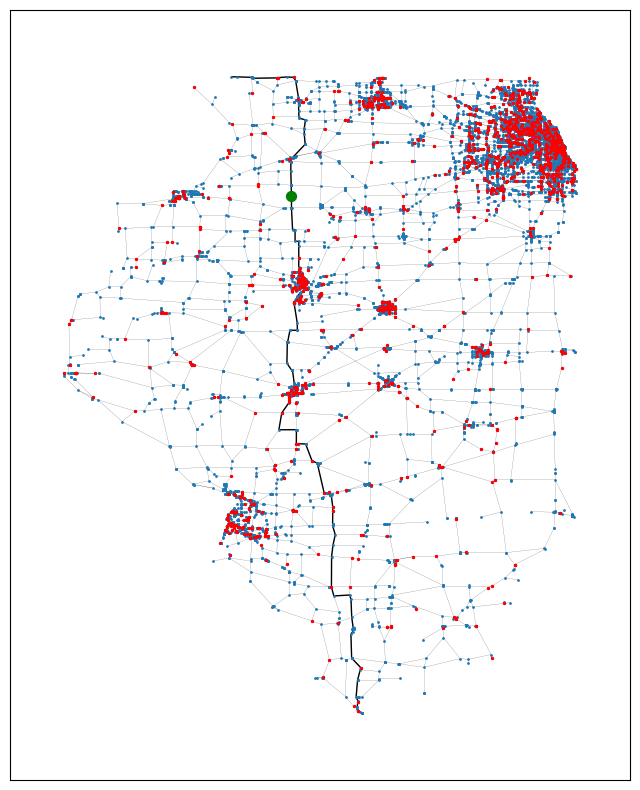

In [68]:
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(data=False),node_size=1)
nx.draw_networkx_edges(G,pos,edgelist=G.edges(data=False),width=0.1,arrows=False)
nx.draw_networkx_nodes(G,pos,nodelist=gas_stations,node_color='r',node_size=2)
nx.draw_networkx_edges(G,pos,edgelist=path_as_edgelist(mpath),width=1,arrows=False)
nx.draw_networkx_nodes(G,pos,nodelist=fill_stations,node_color='g',node_size=50)
plt.show()

In [69]:
print(fill_stations, fill_qty)

[233947770.0] [8.0]
